# 0. 운영체제 과제 01
- 201901763 이지호

과제 1
마감 : 4월 30일(일) 저녁 6시까지
내용 :
수업때 이야기한 모든 스케줄링 방법을 구현하고 성능(5가지) 비교
Json 파일로 입력정보를 주면 포맷을 체크해서 비교판단
실시간스케줄링과 비실시간스케줄링을 Json  입력파일로 자동 구분처리
파이썬만 사용, 간트차트 출력을 포함하여 5가지를 모두 비교하고, 각 입력 데이터에 대해 그 중 종합적으로 제일 나은 방법을 "자동" 결과 리포팅 (리포팅 내용을 간단한 설명을 포함하여 자동 생성)
숫자 결과와 그래픽결과를 모두 나타내고 자동으로 리포팅
chatGPT 포함한 외부 자료 사용 절대 금함. 특성을 이미 잘 알고 있으므로,  사용흔적이 보이면 0점 처리

MarkDown 문서로 설명과 해설 그리고 주석이 포함된 주피터노트북 파일(*.ipynb 파일) 과 해당 파일을 PDF 로 저장한 파일, 
입력에 사용하는 json 파일 3개 (입력예제 3개임) 등, 
총 5개를 이러닝 사이트에 제출함.

실행 결과는 절대 평가함. (제대로 되었는지 여부, 제출한 입력 포맷에 평가 데이터를 적용해서 진행)
전체 결과는 등급제로 상대 평가함. 열심히 코드 만들고, 열심히 최선의 결과를 잘 만든 사람에게 높은 등급

위 내용을 기준으로 추가로 필요한 부분은 스스로 판단해서 진행하면 됨. 의도에서 벗어나거나 축소되면 안됨.


- First-come, First-Served (선입선출)
- Shortest-Job-First (최단작업우선)
- Shortest-remaining-time-first (최단잔여시간우선)
- Priority (우선순위)
- Round robin(퀀텀타임대로 순회)
- Priority + Round robin

# 1. 분석 준비

## 1.1. Load data
- 아래 변수 숫자 (int) 변경해가며, (1), (2), (3)번 case 마다 실행 가능.

In [80]:
import copy
import matplotlib.pyplot as plt
import json
import numpy as np

# case_[NUM] 변경해가며 출력 가능
_casenum = 1
# 입력할 전체 프로세스들의 시간 길이
_MAX_TIME_LENGTH_ = 999
# Round robin
_QUANTUM_TIME_ = 30


def data_loader():
    print("--Data_loader-----------------")
    _jsonfilename = "case" + str(_casenum) + ".json"
    with open(_jsonfilename) as f:
        json_object = json.load(f)

    num_of_processs = len(json_object['list'])
    print("- Num of Process :", num_of_processs)

    # data checking
    assert json_object['list']
    for i in range(num_of_processs):
        assert json_object['list'][i]["Num"] > 0
        assert json_object['list'][i]["Burst_time"] > 0
        assert json_object['list'][i]["Priority"] > 0
        assert json_object['list'][i]["Arrival_time"] >= 0
    print("- Data Loading Success")
    print("------------------------------")

    return json_object

_DATA_ = data_loader()["list"]


--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------


## 1.2. Function

In [81]:
_ALL_JOB_IS_DONE_ = -999
_NON_PROCESS_ = -1

def draw(_process, _order):
    print("- Order is :", _order)
    print("--Start Analysis--------------")
    fig, ax = plt.subplots(figsize=(10, 1))

    _sum_of_busrt_time = 0
    _sum_of_response_time = 0
    _sum_of_turnaround_time = 0
    _sum_of_running_time = 0
    _now_time = 0
    _cumsum_waiting_time = 0

    _xlim_tickers = []

    # 완전동작 카운터
    _start_counter = 0
    _done_counter = 0


    for _pid, _runtime in _order:
        # NOT CPU RUNNING
        if (_pid < 0):
            if (_runtime > 0):
                # TAKE A REST
                _now_time += _runtime
            elif (_runtime == _ALL_JOB_IS_DONE_):
                # ALL JOP IS DONE
                break
        # CPU RUNNING
        else:
            # P_num은 1부터 시작하기에, index 맞추는 용도.
            _JUST_PRINT_IDX_ = _pid
            for i in range(len(_process)):
                if (_process[i]['Num'] == _pid):
                    _target = _process[i]
            _pid -= 1
            
            #_original_process_list대신에, target의 우선순위에 음수로 시작시간 저장
            # First come in CPU
            if (_target['Priority'] > 0):
                _sum_of_response_time += _now_time
                print("START - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                # 파라미터의 Priority 시작시간 메모장으로 사용함.
                # order는 정해져있고, Priority는 이 단계에서 사용하지 않음.
                _target['Priority'] = 0
                _target['Priority'] = - _now_time
                _start_counter += 1
            
            # if (_process[_pid]['Burst_time'] >= _runtime):
            _sum_of_busrt_time += _target['Burst_time']
            _cumsum_waiting_time += _now_time
            
            ax.barh(0, _runtime, left=_now_time, edgecolor='black')
            _now_time += _runtime
            ax.text(_now_time - _runtime/2, 0,
                    ('P'+str(_target['Num'])), ha='center', va='center')
            
            # burst_time - running time
            _target['Burst_time'] -= _runtime
            # JOP IS DONE ?
            if (_target['Burst_time'] == 0):
                # print(" P", _JUST_PRINT_IDX_, "Turnaround time is",_now_time - _target['Arrival_time'])
                _sum_of_turnaround_time += _now_time - _target['Arrival_time']
                # print(" P", _JUST_PRINT_IDX_, "Running    time is", _now_time -abs(_target['Priority']))
                _sum_of_running_time += _now_time - abs(_target['Priority'])
                print("EXIT  - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                # print("")
                _done_counter +=1
        _xlim_tickers.append(_now_time)
    
    # ploting
    print("------------------------------")
    ax.set_xticks(_xlim_tickers)
    ax.set_xlim([0, _now_time])
    ax.set_yticks([])
    if (_start_counter != len(_process)):
        print("응 오류야 ㅋㅋ~ 정상시작 횟수 :", _start_counter)
    else:
        print("ALL START GOOD JOB!!!")
    if (_done_counter != len(_process)):
        print("응 오류야 ㅋㅋ~ 정상종료 횟수 :", _done_counter)
    else:
        print("ALL EXIT  GOOD JOB!!!")
    plt.show()
    

    # print value
    # cpu 이용률
    # print("CPU utilization : %2.2f" % float(_sum_of_busrt_time/_now_time*100), "%")
    # # 단위 시간당 처리된 프로세스의 개수
    # print("Throughput :", len(_process)/_now_time)
    # # 프로세스를 cpu가 실행하지 않은 평균 대기시간
    # print("Average waiting time :", _cumsum_waiting_time/len(_process))
    # # 프로세스를 처음으로 실행하는 데에 걸린 시간
    # print("Average Response time :", _sum_of_response_time/len(_process))
    # # 시작하고 나서부터 완료까지 걸린 시간
    # print("Average Running time :", _sum_of_running_time/len(_process))
    # # 처음 대기 부터, 작업 완료에 대한 총 소요 시간 / p's 종료시점 - arrival_time
    # print("Average Turnaround time :", _sum_of_turnaround_time/len(_process))

# 2. 비선점형

## 2.1. First-come, First-Served (선입선출) OK
- 도착시간만 고려
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[1, 30], [3, 102], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 1     time is 0
EXIT  - P 1     time is 30
START - P 3     time is 30
EXIT  - P 3     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


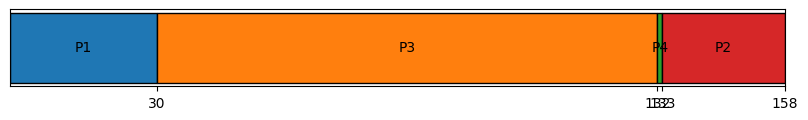

In [82]:
_order = []
_list = data_loader()['list']
_copy = copy.deepcopy(_list)
_list = sorted(_list, key=lambda x: x['Arrival_time'])

for _sorted_process in _list:
    _order.append([_sorted_process['Num'], _sorted_process['Burst_time']])
    
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)


## 2.2. Shortest-Job-First (최단작업우선) OK
- Burst_time만 고려
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[1, 30], [3, 102], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 1     time is 0
EXIT  - P 1     time is 30
START - P 3     time is 30
EXIT  - P 3     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


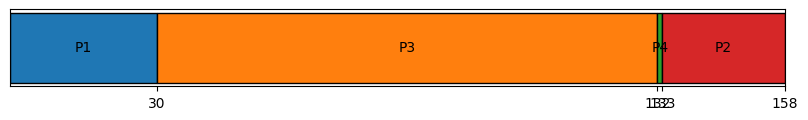

In [83]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)

for _now_time in range(_MAX_TIME_LENGTH_):
    _sort_target_process = []
    # 도착시간 동일한 process들 모으기
    for _process in _list:
        if(_now_time == _process['Arrival_time']):
            _sort_target_process.append(_process)
    # Burst_time 기준으로 오름차순 정렬
    _sort_target_process = sorted(_sort_target_process, key=lambda x: x['Burst_time'])
    # 그대로 스케쥴링 진행
    for _sorted_process in _sort_target_process:
        _order.append([_sorted_process['Num'], _sorted_process['Burst_time']])
# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)


## 2.3. Priority First Served (우선순위먼저) OK
- Burst_time, Priority 고려
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- 우선 순위 동일 시 프로세스 번호 순

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[3, 102], [1, 30], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 3     time is 0
EXIT  - P 3     time is 102
START - P 1     time is 102
EXIT  - P 1     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


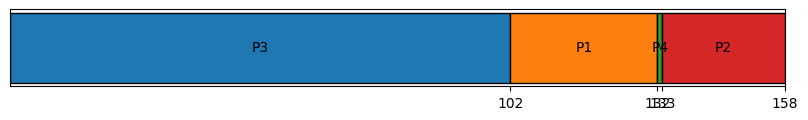

In [84]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)
for _now_time in range(_MAX_TIME_LENGTH_):
    _sort_target_process = []
    # 도착시간 동일한 process들 모으기
    for _process in _list:
        if(_now_time == _process['Arrival_time']):
            _sort_target_process.append(_process)
    # Priority 기준으로 오름차순 정렬
    _sort_target_process = sorted(
        _sort_target_process, key=lambda x: x['Priority'])
    # 그대로 스케쥴링 진행
    for _sorted_process in _sort_target_process:
        _order.append([_sorted_process['Num'], _sorted_process['Burst_time']])
# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)


## 2.4. Round robin(퀀텀타임대로 순회) OK
- Burst_time만 고려
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[1, 30], [3, 30], [3, 30], [3, 30], [3, 12], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 1     time is 0
EXIT  - P 1     time is 30
START - P 3     time is 30
EXIT  - P 3     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


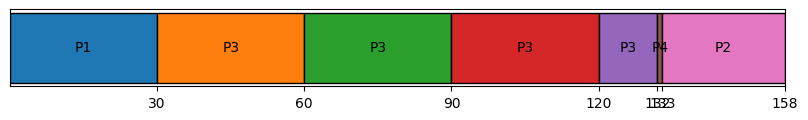

In [85]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)

_remainder = []

for _now_time in range(_MAX_TIME_LENGTH_):

    # 도착하면 수행 가능 리스트에 넣기
    for _process in _list:
        if (_now_time == _process['Arrival_time']):
            _remainder.append(_process)
    # print(_now_time, _remainder)
    # 리스트 내에서 스케쥴링 진행
    for _sorted_process in _remainder:
        # 남은 작업이 있을 때에,
        if (_sorted_process['Burst_time'] > 0):
            # 더 적게 남으면 Burst_time만
            if (_sorted_process['Burst_time'] < _QUANTUM_TIME_):
                _order.append(
                    [_sorted_process['Num'], _sorted_process['Burst_time']])
                _sorted_process['Burst_time'] -= _sorted_process['Burst_time']
            # 동일하거나 더 많이 남으면 _QUANTUM_TIME_ 만큼만
            else:
                _order.append([_sorted_process['Num'], _QUANTUM_TIME_])
                _sorted_process['Burst_time'] -= _QUANTUM_TIME_

# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)


## 2.5. Priority + Round robin OK

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[3, 30], [1, 30], [3, 30], [3, 30], [3, 12], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 3     time is 0
START - P 1     time is 30
EXIT  - P 1     time is 60
EXIT  - P 3     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


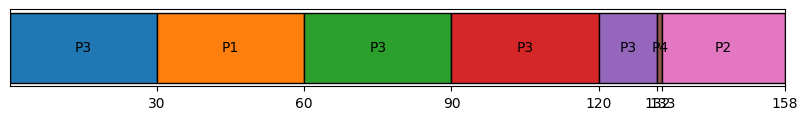

In [86]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)

_remainder = []

for _now_time in range(_MAX_TIME_LENGTH_):

    # 도착하면 수행 가능 리스트에 넣기
    for _process in _list:
        if (_now_time == _process['Arrival_time']):
            _remainder.append(_process)
    # Priority 기준으로 오름차순 정렬
    _remainder = sorted(_remainder, key=lambda x: x['Priority'])
    # 리스트 내에서 스케쥴링 진행
    for _sorted_process in _remainder:
        # 남은 작업이 있을 때에,
        if (_sorted_process['Burst_time'] > 0):
            # 더 적게 남으면 Burst_time만
            if (_sorted_process['Burst_time'] < _QUANTUM_TIME_):
                _order.append(
                    [_sorted_process['Num'], _sorted_process['Burst_time']])
                _sorted_process['Burst_time'] -= _sorted_process['Burst_time']
            # 동일하거나 더 많이 남으면 _QUANTUM_TIME_ 만큼만
            else:
                _order.append([_sorted_process['Num'], _QUANTUM_TIME_])
                _sorted_process['Burst_time'] -= _QUANTUM_TIME_
# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)


# 3. 선점형

## 3.1. Shortest-Job-First (최단작업우선)
- Arrival_time, Burst_time 고려

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
[[1, 30], [3, 102]]
[[1, 30], [3, 102]]
[[1, 30], [3, 102]]
{'Num': 4, 'Burst_time': 1, 'Priority': 2, 'Arrival_time': 3}
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 102], [4, 1]]
[[1, 30], [3, 10

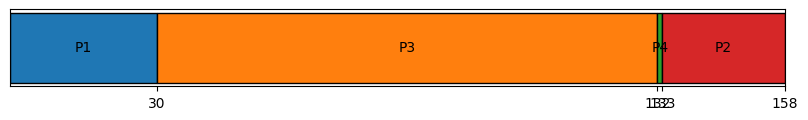

In [87]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)

_cnt=0
for _now_time in range(_MAX_TIME_LENGTH_):
    _cnt+=1
    _sort_target_process = []
    # 도착시간 동일한 process들 모으기
    for _process in _list:
        if(_now_time == _process['Arrival_time']):
            _sort_target_process.append(_process)
            # init 이후에 도착한 process가
            if(_now_time != 0):
                print(_process)
    # Burst_time 기준으로 오름차순 정렬
    _sort_target_process = sorted(_sort_target_process, key=lambda x: x['Burst_time'])
    
    # 그대로 스케쥴링 진행
    for _sorted_process in _sort_target_process:
        _order.append([_sorted_process['Num'], _sorted_process['Burst_time']])
    print(_order)
    ###
    # [[2, 25], [1, 30], [3, 102]]
    # [[2, 25], [1, 30], [3, 102], [4, 1]]
    # [[2, time], [4, 1], [2, 25-time], [1, 30], [3, 102]]
    ###
    
# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
print(_cnt)
draw(_copy, _order)


## 3.2. Priority First Served (우선순위먼저)
- Burst_time, Priority 고려
- Starvation 고려한 Aging 실행


--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[3, 102], [1, 30], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 3     time is 0
EXIT  - P 3     time is 102
START - P 1     time is 102
EXIT  - P 1     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


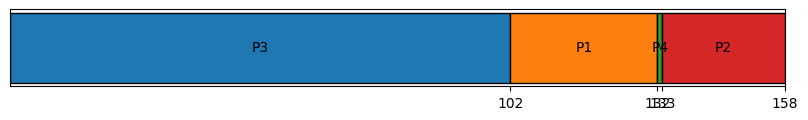

In [88]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)

for _now_time in range(_MAX_TIME_LENGTH_):
    _sort_target_process = []
    # 도착시간 동일한 process들 모으기
    for _process in _list:
        if(_now_time == _process['Arrival_time']):
            _sort_target_process.append(_process)
    # Priority 기준으로 오름차순 정렬
    _sort_target_process = sorted(
        _sort_target_process, key=lambda x: x['Priority'])
    # 그대로 스케쥴링 진행
    for _sorted_process in _sort_target_process:
        _order.append([_sorted_process['Num'], _sorted_process['Burst_time']])
# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)


## 3.3. Shortest-remaining-time-first (최단잔여시간우선)
- Arrival_time, Burst_time 고려

--Data_loader-----------------
- Num of Process : 4
- Data Loading Success
------------------------------
- Order is : [[1, 30], [3, 102], [4, 1], [2, 25], [-1, -999]]
--Start Analysis--------------
START - P 1     time is 0
EXIT  - P 1     time is 30
START - P 3     time is 30
EXIT  - P 3     time is 132
START - P 4     time is 132
EXIT  - P 4     time is 133
START - P 2     time is 133
EXIT  - P 2     time is 158
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


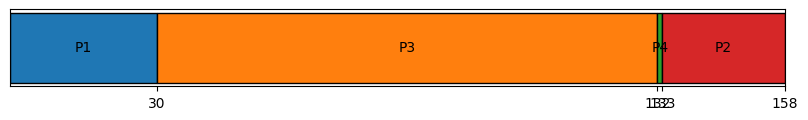

In [89]:
_order = []
_list = data_loader()["list"]
_copy = copy.deepcopy(_list)

for _now_time in range(_MAX_TIME_LENGTH_):
    _sort_target_process = []
    # 도착시간 동일한 process들 모으기
    for _process in _list:
        if(_now_time == _process['Arrival_time']):
            _sort_target_process.append(_process)
    # Burst_time 기준으로 오름차순 정렬
    _sort_target_process = sorted(_sort_target_process, key=lambda x: x['Burst_time'])
    # 그대로 스케쥴링 진행
    for _sorted_process in _sort_target_process:
        _order.append([_sorted_process['Num'], _sorted_process['Burst_time']])
# 종료 사인
_order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])

draw(_copy, _order)
